In [30]:
!pip install -r requirements.txt

In [31]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import json
from shapely.geometry import shape

In [32]:
# Load Zillow ZIP-level price data
# Download from: https://www.zillow.com/research/data/
zillow_df = pd.read_csv("data/Zip_Zhvi_AllHomes.csv")

# Pick latest column (e.g., March 2023)
zillow_df = zillow_df[['RegionName', 'State', 'Metro', '2023-03-31']].dropna()
zillow_df = zillow_df.rename(columns={
    'RegionName': 'zip',
    '2023-03-31': 'price_2023_03'
})
zillow_df['zip'] = zillow_df['zip'].astype(str).str.zfill(5)
zillow_df = zillow_df[zillow_df['State'] == 'CA']

zillow_df.count()

zip              1458
State            1458
Metro            1458
price_2023_03    1458
dtype: int64

In [33]:
# Load NDVI exported from Google Earth Engine
ndvi_df = pd.read_csv("data/NDVI_by_ZIP_CA_2023_Summer.csv")
ndvi_df = ndvi_df.rename(columns={
    'ZCTA5CE10': 'zip',
    'mean': 'ndvi'
})
ndvi_df['zip'] = ndvi_df['zip'].astype(str).str.zfill(5)

# Merge
merged = pd.merge(zillow_df, ndvi_df, on='zip', how='inner')

# Drop NaNs if any
merged = merged.dropna()

# Save for analysis
merged.to_csv("data/zillow_ndvi_merged.csv", index=False)

merged

,zip,State,Metro,price_2023_03,system:index,ALAND10,AWATER10,CLASSFP10,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,MTFCC10,ndvi,.geo
0,90011,CA,"Los Angeles-Long Beach-Anaheim, CA",575299.946693,000100000000000004f0,11100444,515,B5,S,90011,34.007090,-118.258680,G6350,0.106211,"{""type"":""Polygon"",""coordinates"":[[[-118.243137..."
1,90650,CA,"Los Angeles-Long Beach-Anaheim, CA",688517.049025,0001000000000000065e,25408311,96906,B5,S,90650,33.907600,-118.082645,G6350,0.136855,"{""type"":""Polygon"",""coordinates"":[[[-118.111611..."
2,91331,CA,"Los Angeles-Long Beach-Anaheim, CA",667445.089187,000100000000000003bd,22928471,120344,B5,S,91331,34.255442,-118.421313,G6350,0.131292,"{""type"":""Polygon"",""coordinates"":[[[-118.450539..."
3,90044,CA,"Los Angeles-Long Beach-Anaheim, CA",624126.327848,00010000000000000557,13303685,0,B5,S,90044,33.952725,-118.291904,G6350,0.114074,"{""type"":""Polygon"",""coordinates"":[[[-118.300191..."
4,92336,CA,"Riverside-San Bernardino-Ontario, CA",650964.436104,000100000000000003d9,64485907,189585,B5,S,92336,34.147718,-117.464506,G6350,0.164758,"{""type"":""Polygon"",""coordinates"":[[[-117.405294..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,95697,CA,"Sacramento-Roseville-Folsom, CA",523417.328995,00010000000000000197,600257,0,B5,S,95697,38.732368,-121.810263,G6350,0.198257,"{""type"":""Polygon"",""coordinates"":[[[-121.818681..."
1447,95653,CA,"Sacramento-Roseville-Folsom, CA",369719.711865,000100000000000004ae,13137517,21917,B5,S,95653,38.697075,-121.978414,G6350,0.278318,"{""type"":""Polygon"",""coordinates"":[[[-121.969795..."
1448,93222,CA,"Bakersfield, CA",399312.527393,00010000000000000965,73946437,16918,B5,S,93222,34.842425,-119.203723,G6350,0.268308,"{""type"":""MultiPolygon"",""coordinates"":[[[[-119...."
1449,95375,CA,"Sonora, CA",436675.212166,00010000000000000668,7889386,102350,B5,S,95375,38.189554,-120.024082,G6350,0.327029,"{""type"":""Polygon"",""coordinates"":[[[-120.068466..."


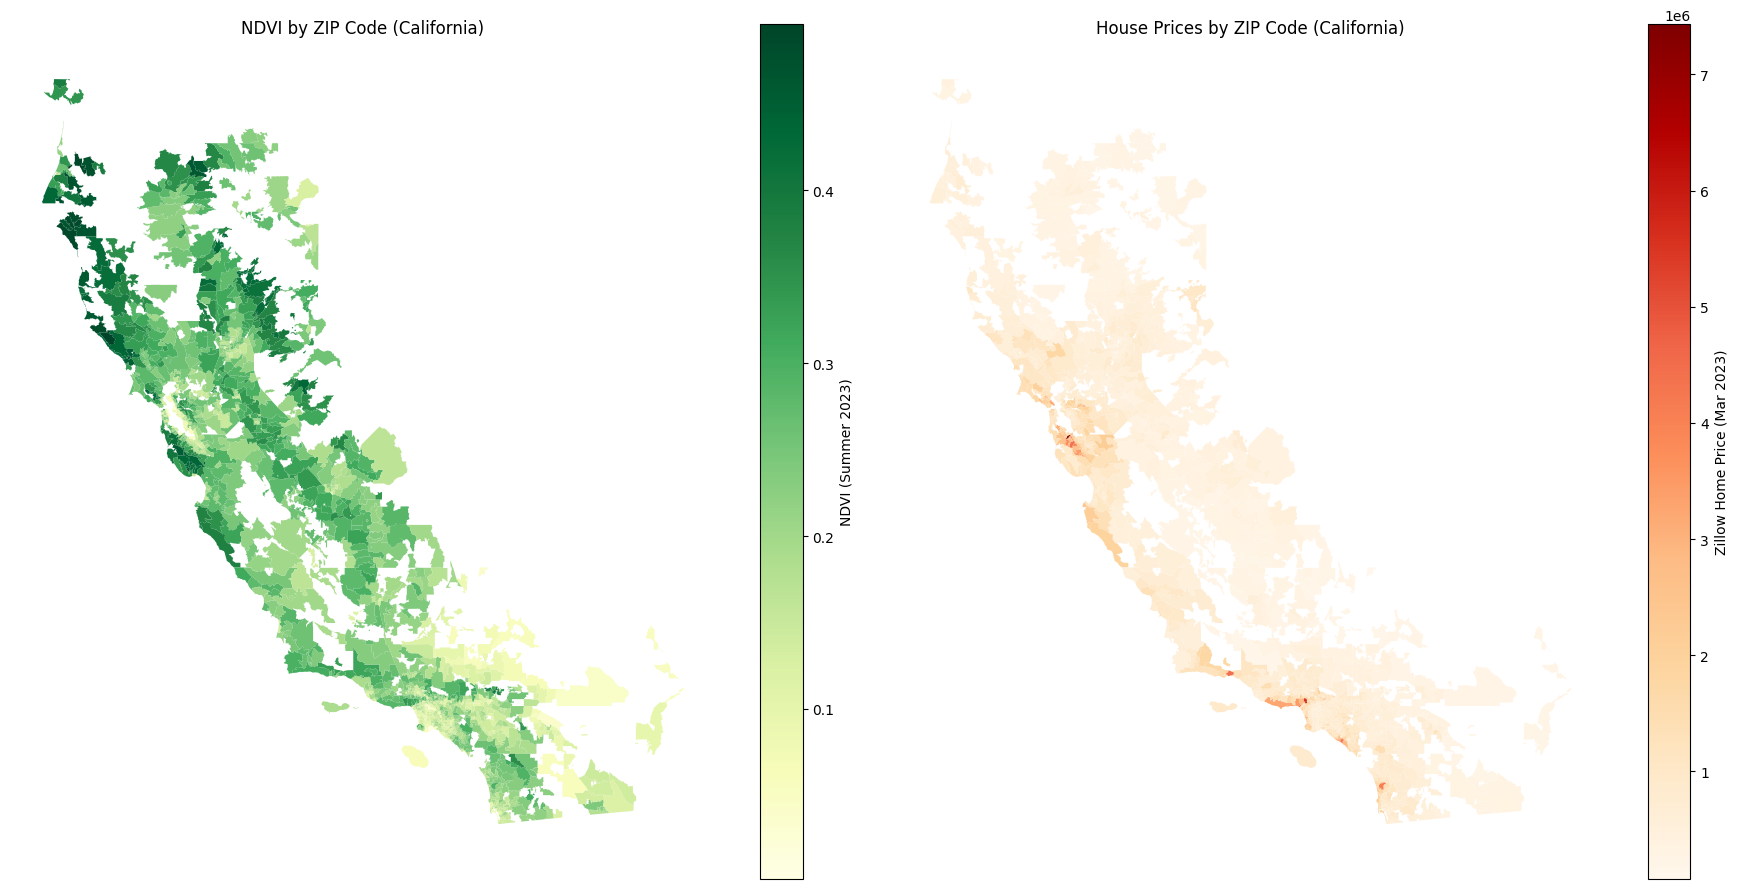

In [34]:
# Load the merged CSV with GeoJSON-style geometry
merged_df = pd.read_csv("data/zillow_ndvi_merged.csv")

# Convert WKT to shapely geometries
merged_df['.geo'] = merged_df['.geo'].apply(json.loads).apply(shape)

# Create a GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='.geo', crs="EPSG:4326")

# Plot NDVI and House Price
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

# NDVI Map
merged_gdf.plot(column='ndvi', cmap='YlGn', legend=True,
                legend_kwds={'label': "NDVI (Summer 2023)"},
                ax=ax[0])
ax[0].set_title("NDVI by ZIP Code (California)")

# House Price Map
merged_gdf.plot(column='price_2023_03', cmap='OrRd', legend=True,
                legend_kwds={'label': "Zillow Home Price (Mar 2023)"},
                ax=ax[1])
ax[1].set_title("House Prices by ZIP Code (California)")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()